In [2]:
import tensorflow as tf
model = tf.keras.models.load_model("../model/LSTM.keras")

In [3]:
from pandas import read_csv
#Load data set
series_influ_A_df = read_csv('../data/vietnam_flu_A.csv', usecols=[1], engine='python')
# series_influ_A_df = series_influ_A_df["Influenza A - All types of surveillance"]
series_influ_A_df = series_influ_A_df.dropna()
series_influ_A_df = series_influ_A_df.astype('float32')
series_influ_A_df = series_influ_A_df.values
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(series_influ_A_df)
# Create Training and Test
train = dataset[:735, :]
test = dataset[735:, :]

In [4]:
import numpy as np
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [5]:
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [6]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [44]:
from sklearn.metrics import mean_squared_error
# [[1,3]] :shape 1,2
def predict_one(X, model):
    X= np.array([X])
    predicted = model.predict(X, verbose=0)
    return predicted[0]


#X_start: [[1,3]]
def predict(X_start, num_weeks, model):
    result = []
    X=np.array([X_start])
    for i in range(num_weeks):
        predicted = predict_one(X[i], model)
        result.append(predicted)
        X_continue = np.array([[[X[i][0][1], predicted[0]]]])

        X = np.append(X, X_continue, axis=0)
    return result
    
# make predictions
# testPredict = model.predict(testX)
testPredict = predict(testX[0], len(testX), model)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform([testY])
# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(testY_[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 13.27 RMSE


[15.87175476 16.0841116  16.23437051 16.38820346 16.53524144 16.67740407
 16.81462047 16.94712523 17.0750931  17.19869636 17.31809997 17.43346154
 17.54492283 17.65263289 17.75672493 17.85732723 17.95456444 18.04855751
 18.13941764 18.2272548  18.31217408 18.39427689 18.47365731 18.55041066
 18.62462614 18.69638927 18.7657807  18.8328823  18.89777227 18.9605227
 19.02120691 19.07989087 19.13664302 19.19152689 19.2446048  19.29593417
 19.34557611 19.39358682 19.44001884 19.48492105 19.52834721 19.57034497
 19.61096077 19.65024226 19.68822976 19.72496848 19.76049875 19.79485845
 19.82808667 19.86022251 19.8913002  19.92135638 19.9504216  19.97852886] [26.99999969 18.00000061 13.99999939 14.99999969 18.00000061 13.00000031
 17.00000031 14.99999969  5.          8.          1.          1.
  5.          1.          1.          0.          0.          0.
  1.          1.          4.          1.          3.          1.
  4.          4.          3.          6.          5.          9.00000031
  

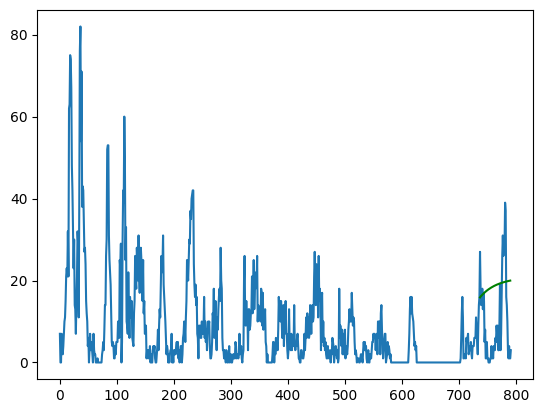

In [49]:
print(testPredict[:, 0], testY_[0])

import matplotlib.pyplot as plt
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainX)+(look_back*2)+1:len(dataset)-1, :] = testPredict
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot, color = 'green')
plt.show()